In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import random
import itertools
%matplotlib inline

### The Problem

In [2]:
def f(x, y, alpha):
    return alpha * x * y


def g(x, y, alpha):
    return - alpha * x * y

x_init = 0.5
y_init = 0.5

alphas = [1., 3., 6.]
learning_rates = [0.04, 0.2, 1.]
experiments = list(itertools.product(alphas, learning_rates))

n_updates = 100

### GDA (Gradient Descent Ascent)

In [3]:
# GDA

def GDA_step(x, y, out_f, out_g, eta=None):
    df_dx = torch.autograd.grad(outputs=out_f, inputs=x, create_graph=False)[0]
    dg_dy = torch.autograd.grad(outputs=out_g, inputs=y, create_graph=False)[0]
    return df_dx, dg_dy


# CGD

def CGD_step(x, y, out_f, out_g, eta):
    df_dx = torch.autograd.grad(outputs=out_f, inputs=x, create_graph=True)[0]
    dg_dy = torch.autograd.grad(outputs=out_g, inputs=y, create_graph=True)[0]

    d2f_dxdy = torch.autograd.grad(outputs=df_dx, inputs=y, create_graph=False)[0]
    d2g_dydx = torch.autograd.grad(outputs=dg_dy, inputs=x, create_graph=False)[0]

    step_x = ((1. / (1. - (eta ** 2.) * d2f_dxdy * d2g_dydx)) * (df_dx - eta * d2f_dxdy * dg_dy))
    step_y = ((1. / (1. - (eta ** 2.) * d2g_dydx * d2f_dxdy)) * (dg_dy - eta * d2g_dydx * df_dx))

    return step_x, step_y


# LCGD (LOLA)

def LCGD_step(x, y, out_f, out_g, eta):
    df_dx = torch.autograd.grad(outputs=out_f, inputs=x, create_graph=True)[0]
    dg_dy = torch.autograd.grad(outputs=out_g, inputs=y, create_graph=True)[0]

    d2f_dxdy = torch.autograd.grad(outputs=df_dx, inputs=y, create_graph=False)[0]
    d2g_dydx = torch.autograd.grad(outputs=dg_dy, inputs=x, create_graph=False)[0]

    step_x = (df_dx - eta * d2f_dxdy * dg_dy)
    step_y = (dg_dy - eta * d2g_dydx * df_dx)

    return step_x, step_y

### Results

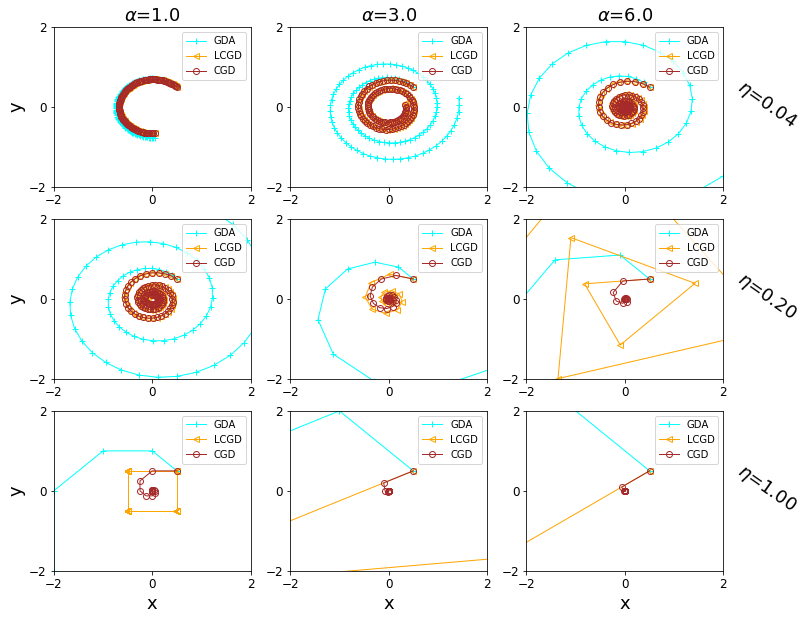

In [4]:
# Execution loops

alg_names = ['GDA', 'LCGD', 'CGD']
alg_updates = [GDA_step, LCGD_step, CGD_step]
colors = ['cyan', 'orange', 'brown']
markers = ['+', '<', 'o']

recorder = {alg_name: {f'alpha={alpha:.1f}, lr={lr:.2f}': [[x_init, y_init]] for alpha, lr in experiments} for alg_name in alg_names}
for alg_name, alg_update in zip(alg_names, alg_updates):
    for (alpha, lr) in experiments:

        x = torch.tensor([x_init], requires_grad=True)
        y = torch.tensor([y_init], requires_grad=True)

        for i in range(n_updates):
            step_x, step_y = alg_update(x=x, y=y, out_f=f(x, y, alpha), out_g=g(x, y, alpha), eta=lr)
            x = x - lr * step_x
            y = y - lr * step_y

            recorder[alg_name][f'alpha={alpha:.1f}, lr={lr:.2f}'].append([x, y])

# Plotting

fig, axes = plt.subplots(3, 3, figsize=(12, 10))
for (j,i), (alpha, lr) in zip(itertools.product(range(3), range(3)), experiments):

    for alg_name, color, marker in zip(alg_names, colors, markers):
        x_s, y_s = np.array(recorder[alg_name][f'alpha={alpha:.1f}, lr={lr:.2f}']).T
        axes[i,j].plot(x_s, y_s, marker=marker, color=color, fillstyle='none', linewidth=1, label=alg_name)

    if i == 0:
        axes[i, j].set_title(rf'$\alpha$={alpha:.1f}', fontsize=18)
    if j == 2:
        axes[i, j].text(s=rf'$\eta$={lr:.2f}', rotation=-35, x=2.2, y=-0.5, fontsize=18)
    if i == 2:
        axes[i, j].set_xlabel('x', fontsize=18)
    if j == 0:
        axes[i, j].set_ylabel('y', fontsize=18)
    axes[i, j].set_xlim(-2, 2)
    axes[i, j].set_ylim(-2, 2)
    axes[i, j].tick_params(axis='both', which='major', labelsize=12)
    axes[i, j].locator_params('x', nbins=3)
    axes[i, j].locator_params('y', nbins=3)
    axes[i, j].legend(loc='upper right')

plt.show()
fig.savefig(f'experiment1.png')